13.12.2020

### Image Processing Physics

#### Julia Herzen, Klaus Achterhold, Clemens Schmid, Manuel Schultheiss


# Exercise 6, Task 2: Connected Components
Have you ever woundered how a battery looks inside?
This exercise will answer all your urgent quesions!

As batteries are produced on a large scale nowadays, non-destructive testing to maintain battery safety can be performed by computed tomography, for example (Further information not needed to solve the exercise: https://www.nature.com/articles/ncomms7924).
We performed a CT scan of a 9V block battery for you and your task is to segment the battery cells using a connected component algorithm and thresholding. Afterwards you determine the median and mean intensity for each battery cell and plot them.

Please note you need to install scikit image to solve this exercise (https://scikit-image.org/docs/dev/install.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
from skimage.measure import label, regionprops

# use inline instead of notebook
%matplotlib inline
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["image.interpolation"] = "none"

# Load a CT scan of a battery
battery = np.load("battery.npy")[:, ::2, ::2]

**Task 1: Min-Max Normlization: **
First we want to normalize the intensity values to a $[0, 1]$ range (e.g. the highest value in the array should be 1 and the lowest value should be 0).

In the original CT scan, the intesities may also have negative values such as -2. Use `battery.min()` and `battery.max()` to find the minimum and maximum.  Mathematically, from each voxel $v_i$ the minimum instensity of the whole scan is subtracted and afterwards it is divided by the intensity range:


$$\mathrm{v}_i=\frac{\mathrm{v}_i-\min(\mathrm{battery})}{\max(\mathrm{battery})-\min(\mathrm{battery})}$$

In [2]:
battery -= battery.min()
battery /= battery.max()

Some assertion code to ensure everything was implemented correctely:

In [3]:
assert np.isclose(battery.max(), 1) 
assert np.isclose(battery.min(), 0)

The following function displays a 3D scan for you, where you can inspect the slice stack by using a slider.

In [4]:
def show_ct(ctscan, colors=False):
    def f(ct_slice_index):
        fig, ax=plt.subplots(dpi=200)
        ax.imshow(ctscan[ct_slice_index], cmap="gray" if not colors else "viridis", vmin=0, vmax=1)
        plt.show()  # add plt.show()

    interactive_plot = interactive(f, ct_slice_index=(0,9))
    output = interactive_plot.children[-1]
    display(interactive_plot)
    plt.show()   # add plt.show()
           
show_ct(battery)

interactive(children=(IntSlider(value=4, description='ct_slice_index', max=9), Output()), _dom_classes=('widge…

**Task 2: Binary Thresholding** Your task is to threshold the scan to a value above 0.42. `thresholded_battery` battery should contain `True` for values > 0.42 and `False` for other voxels.

    

In [5]:
thresholded_battery = battery > 0.42
show_ct(thresholded_battery.astype(np.int32))

interactive(children=(IntSlider(value=4, description='ct_slice_index', max=9), Output()), _dom_classes=('widge…

**Task 3: Connected components ** Use the label function from skimage to assign an unique integer value to each connected group of voxels

In [6]:
label_image = label(thresholded_battery)
label_image.shape

(10, 384, 258)

We can inspect the result using our `plt.imshow` function for the 4th slice:

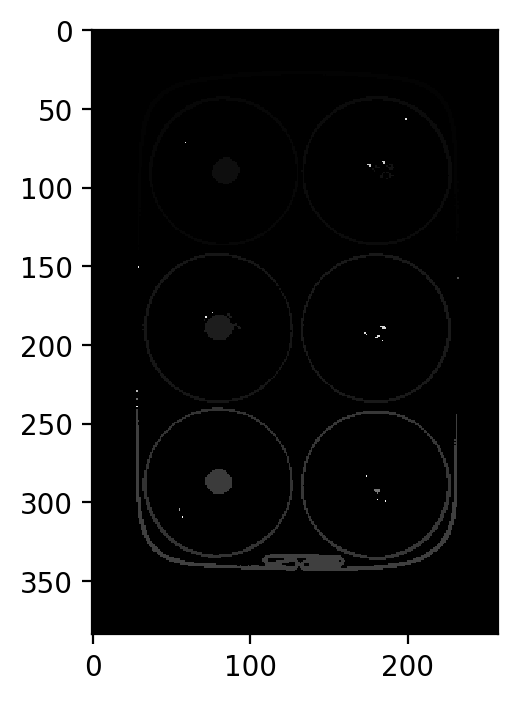

In [7]:
plt.figure(dpi=200)
plt.imshow(label_image[5])
#show_ct(label_image)

**Task 4: Extract Battery Cells: **  Battery cells in our scan have between 4000 and 6000 voxels. Add the `region.bbox` property of regions with a voxel count within that range to the list `regions`. You can access the voxel count of each connected component using `region.area`.

In [8]:
regions = []

for region in regionprops(label_image):
    if region.area >= 4000 and region.area < 6000: # ???
        regions.append(region.bbox)

In [9]:
# see methods and properties of the `region` object
print(dir(region))

# selected region bbox's
regions

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cache', '_cache_active', '_intensity_image', '_intensity_image_double', '_label_image', '_ndim', '_slice', 'area', 'bbox', 'bbox_area', 'centroid', 'convex_area', 'convex_image', 'coords', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', 'filled_area', 'filled_image', 'image', 'inertia_tensor', 'inertia_tensor_eigvals', 'intensity_image', 'label', 'local_centroid', 'major_axis_length', 'max_intensity', 'mean_intensity', 'min_intensity', 'minor_axis_length', 'moments', 'moments_central', 'moments_hu', 'moments_normalized', 'orientation', 'perimeter', 'slice', 'solidity', 'weighted_centroid', 'weighted_lo

[(0, 42, 36, 10, 137, 131),
 (0, 42, 133, 10, 137, 229),
 (0, 142, 32, 10, 237, 128),
 (0, 142, 133, 10, 237, 228),
 (0, 240, 32, 10, 336, 128),
 (0, 242, 133, 10, 337, 228)]

Next we want to show each battery cell. This helper function will return a subvolume when providing a battery cell number.

In [10]:
def get_cell(cell_index):
    """
        Args: 
            cell_index: The cell number. Can be 0, 1,2,3,4,5 or 6
    """
    assert cell_index in range(0, 7)
    r = regions[cell_index]
    return battery[r[0]:r[3], r[1]:r[4], r[2]:r[5]]

In [11]:
# Show the 3D volume of cell 1
show_ct(get_cell(4))

interactive(children=(IntSlider(value=4, description='ct_slice_index', max=9), Output()), _dom_classes=('widge…

**Task 5: Plot Median and Mean **  
Next, we want to extract mean intensity and maximum intensity for each cell and plot it into a scatterplot. Hereby, we create a colormap first. Your task is to extract the mean and median intensity from each slice in each cell (Consequently you need to have 48 values for mean and median each, as there are 6 cells with 8 slices each). Plot these values using a scatterplot, wherby the x-axis defines the mean instensiy and the y-axis defines the median intensity.

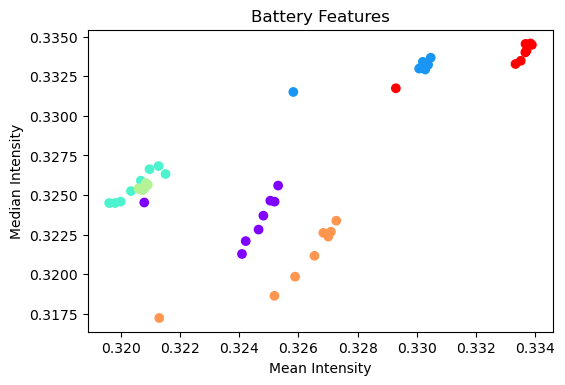

In [12]:
import matplotlib.cm as cm
colormap = cm.rainbow(np.linspace(0, 1, 6)) 

means = []
medians = []
colors = []

for cell in range(0, 6):
    for slice_index in range(1, 9): # We do not use the first and the last slice
        cell_slice = get_cell(cell)[slice_index]
        means.append(np.mean(cell_slice)) 
        medians.append(np.median(cell_slice))
        colors.append(colormap[cell])

plt.figure(dpi=100)
        
plt.title("Battery Features")
plt.xlabel("Mean Intensity")
plt.ylabel("Median Intensity")

plt.scatter(means, medians, color=colors)

The code above was meant to guide you to the solution. The code below achieves the same results in a more concise way while providing labeling of the cells.

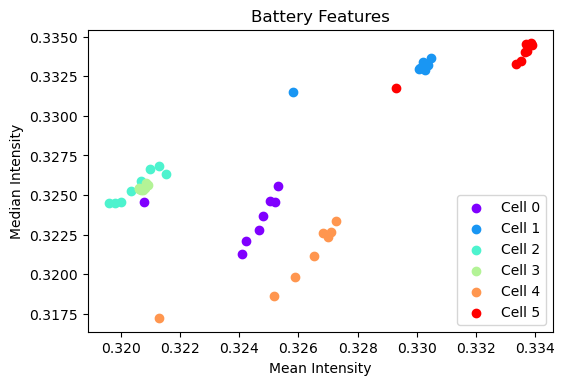

In [13]:
import matplotlib.cm as cm
colormap = cm.rainbow(np.linspace(0, 1, 6)) 

plt.figure(dpi=100)

for cell_index in range(0, 6):
    cell = get_cell(cell_index)[1:-1]
    means = np.mean(cell, axis=(1, 2))
    medians = np.median(cell, axis=(1, 2))
    plt.scatter(means, medians, color=colormap[cell_index], label="Cell %i" % cell_index)

plt.title("Battery Features")
plt.xlabel("Mean Intensity")
plt.ylabel("Median Intensity")
plt.legend()